In [1]:
import tidy3d as td
import tidy3d.plugins.adjoint as tdadjoint
from tidy3d.plugins.adjoint import (
    JaxBox, JaxMedium, JaxStructure, JaxSimulation, JaxSimulationData, JaxDataArray
)
from tidy3d import material_library, Structure, FieldData
from tidy3d.web import run as run_sim
from tidy3d.plugins.adjoint.web import run_local as run_adjoint
from tidy3d.plugins.adjoint.utils.filter import BinaryProjector


from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import jax 
import jax.numpy as jnp
import optax
import os
import h5py

f(p0, p1, ..., p4) = output (float)

output = [flux_f0, flux_f1, ..., flux_ftarget, ..., flux_fN] * [-1, -1, ..., 1, ..., -1]

## Create Simulation Structures

### Define basic simulation parameters

In [2]:
wvl0 = 0.6 # microns
freq0 = td.constants.C_0 / wvl0 
wvl_range = [0.5, 0.7] # microns
freq_range = [td.constants.C_0 / wvl_range[1], td.constants.C_0 / wvl_range[0]]
fwidth = 0.18 * (freq_range[1] - freq_range[0])
freq_points = 101

run_time = 500 / fwidth

monitor_freqs = np.linspace(freq_range[0], freq_range[1], freq_points)
monitor_wvls = td.constants.C_0 / monitor_freqs

buffer_size = wvl0 # distance between the source/monitor and the computational domain
distance = wvl0 # distance between the source/monitor and the structure

# Define the structure
# Substrate information (4 layers of substrates incl. metal and dielectric)
sub_metal_thickness = 0.05
sub_dielectric_min_thickness = 0.05
sub_dielectric_max_thickness = 0.5

# permittivity0 = 3.9 # Assume SiO2 is used as the dielectric substrate
permittivity0 = 2.25 # Assume TiOx is used as the dielectric substrate
Copper= material_library['Cu']['RakicLorentzDrude1998']
TiO2 = material_library['TiOx']['Horiba']
Gold = material_library['Au']['JohnsonChristy1972']
Palladium = material_library['Pd']['JohnsonChristy1972']

# Cuboid information
cuboid_min_length = 0.1
cuboid_max_length = 0.5
cuboid_min_width = 0.1
cuboid_max_width = 0.5
cuboid_min_height = 0.1
cuboid_max_height = 0.5

# Simulation domain
min_steps_per_wvl = 24
dl = wvl0 / min_steps_per_wvl
Lx = 0.5
Ly = 0.5
Lz = 3 * buffer_size + distance + \
     2 * sub_metal_thickness + 2 * sub_dielectric_max_thickness + cuboid_max_height

### Define source and monitor objects

Monitors used in this context are field monitors, as JaxSimulation does not support flux monitors. Therefore, the flux is calculated using field monitors, which are compatible with JaxSimulation.

In [3]:
SOURCE_PLANEWV_NAME = 'source_planewave'
SOURCE_PLANEWV_UPDATED_NAME = 'source_planewave_updated'
FIELD_MONITOR_NAME = 'monitor_field'
FIELD_MONITOR_UPDATED_NAME = 'monitor_field_updated'
FLUX_MONITOR_NAME = 'monitor_flux'

source_planewave = td.PlaneWave(
    center = (0, 0, Lz/2 - 2*buffer_size),
    source_time = td.GaussianPulse(freq0 = freq0, fwidth = fwidth),
    size = (td.inf, td.inf, 0),
    direction = '-',
    pol_angle = 0,
    name = SOURCE_PLANEWV_NAME,
)

monitor_field = td.FieldMonitor(
    center = (0, 0, Lz/2 - buffer_size),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    # fields = ['Ex', 'Ey', 'Ez'],
    name = FIELD_MONITOR_NAME,
    colocate = False,
)

monitor_flux = td.FluxMonitor(
    center = (0, 0, Lz/2 - buffer_size),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name = FLUX_MONITOR_NAME,
)

### Function to create the structure

The structure consists of the following components: 

* Stacked substrates of 4 layers, with alterning layers of metals and dielectrics
* Cuboid on top of the substrate

So far I didn't found a method to make metal layers jax-compatible, so metal layers are of fixed thickness of 50 nm. The sizes of dielectric components are to be optimized via inverse design. Specifically, the following parameters are to be optimized: 

* Thicknesses of the dielectric substrates
* Side lengths of the cuboid (length, width and height)

In [4]:
def make_dynamic_structure(slab_info: jnp.array) -> List[JaxStructure]: 
    if slab_info is None:
        return []

    dielectric_thicknesses = slab_info[:2]
    cuboid_length = slab_info[2]
    cuboid_width = slab_info[3]
    cuboid_height = slab_info[4]

    # Substrate
    substrate = []
    z_center = -Lz/2 + buffer_size
    # Metal layer 1 (replaced with high-permittivity dielectric)
    z_center += sub_metal_thickness/2
    substrate.append(
        JaxStructure(
            geometry = JaxBox(
                center = (0, 0, z_center),
                size = (td.inf, td.inf, sub_metal_thickness),
            ),
            medium = JaxMedium(permittivity = 20.0),
        )
    )
    # Dielectric layer 1
    z_center += sub_metal_thickness/2 + dielectric_thicknesses[0]/2
    substrate.append(
        JaxStructure(
            geometry = JaxBox(
                center = (0, 0, z_center),
                # size = (td.inf, td.inf, float(dielectric_thicknesses[0].item())),
                size = (td.inf, td.inf, dielectric_thicknesses[0])
            ),
            medium = JaxMedium(permittivity = permittivity0),
        )
    )
    # Metal layer 2 (replaced with high-permittivity dielectric)
    z_center += dielectric_thicknesses[0]/2 + sub_metal_thickness/2
    substrate.append(
        JaxStructure(
            geometry = JaxBox(
                center = (0, 0, z_center),
                size = (td.inf, td.inf, sub_metal_thickness),
            ),
            medium = JaxMedium(permittivity = 10.0),
        )
    )
    # Dielectric layer 2
    z_center += sub_metal_thickness/2 + dielectric_thicknesses[1]/2
    substrate.append(
        JaxStructure(
            geometry = JaxBox(
                center = (0, 0, z_center),
                size = (td.inf, td.inf, dielectric_thicknesses[1]),
            ),
            medium = JaxMedium(permittivity = permittivity0),
        )
    )

    # Cuboid
    z_center += dielectric_thicknesses[1]/2 + cuboid_height/2
    cuboid = JaxStructure(
        geometry = JaxBox(
            center = (0, 0, z_center),
            size = (cuboid_length, cuboid_width, cuboid_height),
        ),
        medium = JaxMedium(permittivity = permittivity0),
    )

    return substrate + [cuboid]

### Function to create the simulation object

The `make_jsim` function returns a JaxSimulation object with updated internal structures. 

The boundary condition here specifies that along the x and y direction, the pattern repeats infinitely, thus Bloch condition is used. Along z direction, PML condition is used to absorb the waves and avoid reflections.

In [5]:
def make_jsim(slab_info: jnp.array) -> JaxSimulation: 
    boundary_spec = td.BoundarySpec(
        x = td.Boundary.bloch_from_source(
            source = source_planewave, domain_size = Lx, axis = 0,
        ),
        y = td.Boundary.bloch_from_source(
            source = source_planewave, domain_size = Ly, axis = 1,
        ),
        z = td.Boundary.pml(),
    )

    # grid_spec = td.GridSpec.auto(min_steps_per_wvl = min_steps_per_wvl)
    grid_spec = td.GridSpec.auto()
    
    # static_structure = make_static_structure(slab_info)
    dynamic_structure = make_dynamic_structure(slab_info)

    jsim = JaxSimulation(
        size = (Lx, Ly, Lz),
        run_time = run_time,
        boundary_spec = boundary_spec,
        grid_spec = grid_spec,
        structures = [], 
        input_structures = dynamic_structure,
        sources = [source_planewave],
        monitors = [monitor_flux],
        output_monitors = [monitor_field],
        shutoff = 1e-6,
    )

    return jsim

### Check point

This section will check if the structure can be correctly generated using random design information. 

It will also estimate credit usage for each simulation. 

In [6]:
key = jax.random.PRNGKey(0)
random_substrate_thickness = jax.random.uniform(key, (2,), minval=sub_dielectric_min_thickness, maxval=sub_dielectric_max_thickness)
(key, subkey) = jax.random.split(key)
random_cuboid_length = jax.random.uniform(key, (1,), minval=cuboid_min_length, maxval=cuboid_max_length)
(key, subkey) = jax.random.split(key)
random_cuboid_width = jax.random.uniform(key, (1,), minval=cuboid_min_width, maxval=cuboid_max_width)
(key, subkey) = jax.random.split(key)
random_cuboid_height = jax.random.uniform(key, (1,), minval=cuboid_min_height, maxval=cuboid_max_height)
(key, subkey) = jax.random.split(key)
random_design_info = jnp.concatenate([random_substrate_thickness, random_cuboid_length, random_cuboid_width, random_cuboid_height])

random_jsim = make_jsim(random_design_info)
# random_jsim = make_jsim(None)
random_sim, random_jax_info = random_jsim.to_simulation()

random_sim.plot_3d()
plt.show()

random_sim_job = td.web.Job(simulation = random_sim, task_name = "week05_design_Jax_credit_estimation", verbose = True)
estimated_cost = td.web.estimate_cost(random_sim_job.task_id)
print(f"Estimated cost: {estimated_cost}")

17:47:41 BST WARNING: 'JaxSimulation.input_structures[0]' overlaps or touches   
             'JaxSimulation.input_structures[1]'. Geometric gradients for       
             overlapping input structures may contain errors.                   

             WARNING: Suppressed 3 WARNING messages.                            

17:47:42 BST Created task 'week05_design_Jax_credit_estimation' with task_id    
             'fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=805505;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=497697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e\taskId]8;;\]8;id=805505;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e\=]8;;\]8;id=688341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e\fdve]8;;\]8;id=805505;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e\-90a49d46-33b]8;;\
             ]8;id=805505;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90a49d46-33bf-4c1e-bb0e-de0858a68c1e\f-4c1e-bb0e-de0858a68c1e']8;;\.

Output()

17:47:49 BST Maximum FlexCredit cost: 0.079. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

               0.000 FlexCredit of the total cost from post-processing.

Estimated cost: 0.07931613055651753


## Objective Function

This section will define the objective function and the normalized objective function. For normalized function to be defined, an empty structure flux will be first calculated.  

### Process simulation data

This step retrieves flux information from the field data at different frequencies.

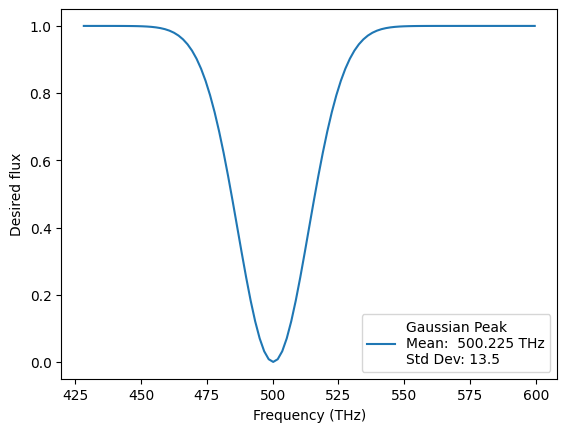

In [7]:
# Create a gaussian distribution that we want to regress to
from jax.scipy.stats import norm as jspnorm

def find_closest_index(array: jnp.array, value: float) -> int:
    idx = (jnp.abs(array - value)).argmin()
    return idx

gaussian_x = jnp.linspace(freq_range[0] / 1e12, freq_range[1] / 1e12, freq_points)
mean_idx = find_closest_index(gaussian_x, freq0 / 1e12)
mean = gaussian_x[mean_idx]
std_dev = 13.5
gaussian_y = jspnorm.pdf(gaussian_x, mean, std_dev)
gaussian_y /= jnp.max(gaussian_y)
gaussian_y = 1 - gaussian_y

plt.plot(gaussian_x, gaussian_y, label=f'Gaussian Peak\nMean: {mean: .3f} THz\nStd Dev: {std_dev}')
plt.xlabel("Frequency (THz)")
plt.ylabel('Desired flux')
plt.legend()
plt.savefig("gaussian_peak.png")
plt.show()

In [8]:
flux_history = []

def get_flux_from_field_data_v2(jsim_data: JaxSimulationData) -> JaxDataArray:
    flux = jsim_data[FIELD_MONITOR_NAME].flux
    return flux

def evaluate_flux_error_v2(flux: JaxDataArray) -> float:
    # Create a gaussian shape penalty array, so that the center deviation will be heavily penalized
    penalty_max = 5.0
    penalty_min = 1.0
    penalty_array = (1 - gaussian_y) * (penalty_max - penalty_min) + penalty_min
    error = jnp.sum(jnp.dot(jnp.square(flux.values - gaussian_y), penalty_array))
    return error
    

### Convert param to design information

Note that BinaryProjector is compatible with Jax.

In [9]:
def params_to_slab_info(params: jnp.array) -> jnp.array:
    if params is None: 
        return None

    param_thicknesses_0_to_1 = 0.5 * (jnp.tanh(params[:2]) + 1)
    param_cuboid_length_0_to_1 = 0.5 * (jnp.tanh(params[2]) + 1)
    param_cuboid_width_0_to_1 = 0.5 * (jnp.tanh(params[3]) + 1)
    param_cuboid_height_0_to_1 = 0.5 * (jnp.tanh(params[4]) + 1)

    binary_projector_thicknesses = BinaryProjector(vmin = sub_dielectric_min_thickness, vmax = sub_dielectric_max_thickness, beta = 1.0)
    binary_projector_cuboid_length = BinaryProjector(vmin = cuboid_min_length, vmax = cuboid_max_length, beta = 1.0)
    binary_projector_cuboid_width = BinaryProjector(vmin = cuboid_min_width, vmax = cuboid_max_width, beta = 1.0)
    binary_projector_cuboid_height = BinaryProjector(vmin = cuboid_min_height, vmax = cuboid_max_height, beta = 1.0)

    thicknesses = binary_projector_thicknesses.evaluate(param_thicknesses_0_to_1)
    length = binary_projector_cuboid_length.evaluate(param_cuboid_length_0_to_1)
    width = binary_projector_cuboid_width.evaluate(param_cuboid_width_0_to_1)
    height = binary_projector_cuboid_height.evaluate(param_cuboid_height_0_to_1)

    return jnp.concatenate([thicknesses, jnp.array([length, width, height])])

### Define the objective function

In [10]:
def generate_unique_task(base_path) -> Tuple[str, str]:
    i = 0
    while True:
        new_path = f"data/{base_path}_{i}.hdf5"
        new_name = f"task_{base_path}_{i}"
        if not os.path.exists(new_path):
            return new_name, new_path
        i += 1

def objective_fn(params: jnp.array) -> Tuple[float, JaxSimulationData]: 
    slab_info = params_to_slab_info(params)
    jsim = make_jsim(slab_info)
    task_name, data_path = generate_unique_task("week05_design_jax_objective_fn")
    jsim_data = run_adjoint(jsim, task_name = task_name, verbose = True, path = data_path)
    flux = get_flux_from_field_data_v2(jsim_data)
    flux_history.append(jsim_data[FLUX_MONITOR_NAME].flux)
    error = evaluate_flux_error_v2(flux)
    return error, jsim_data

val_and_grad_fn = jax.value_and_grad(objective_fn, has_aux = True)

### Run an empty structure simulation

For this application, there is no need to simulate an empty structure. Thus, the normalized objective function is left empty.

However, this section is reserved for framework integrity. 

### Define the normalized objective function

## Optimization

### Calculate the initial state

An initial state is set with values slightly below the medium values. 

If 100% sure that the code works as expected, this step can be omitted. The expected output will be some numbers in the gradient array, the same size as the parameter array. 

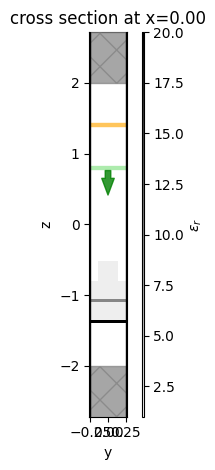

In [11]:
PARAMS0 = -0.1 * jnp.ones(5)

jsim_initial = make_jsim(params_to_slab_info(PARAMS0))
jsim_initial.plot_eps(x = 0)
plt.show()

In [12]:
# (val_intial, jsim_data_initial), grad_initial = val_and_grad_fn(PARAMS0)
# print(f"Initial design\tFlux error: {val_intial}\tGradient: {grad_initial}")

### Visualize the initial state

In [13]:
def plot_flux(itr: int):
    flux = flux_history[-1]
    plt.figure(figsize = (4, 2))
    plt.plot(monitor_freqs / 1e12, flux)
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Flux')
    plt.title(f'Flux at iteration {itr}')
    plt.show()

### Optimization loop

This loop updates the param using the Adam optimizer. 

To visualize the optimization process, several things are done after each iteration: 

* Plot the flux spectrum
* Plot the cross section of the structure


Iteration 1


17:47:50 BST Created task 'task_week05_design_jax_objective_fn_12_fwd' with     
             task_id 'fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=111419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=166931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\taskId]8;;\]8;id=111419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\=]8;;\]8;id=441142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\fdve]8;;\]8;id=111419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\-b16b6737-a51]8;;\
             ]8;id=111419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\4-4d9c-bf30-5b1882d2cc7e']8;;\.

Output()

17:47:52 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:48:03 BST status = preprocess

17:48:04 BST You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

Output()

17:51:47 BST status = postprocess

Output()

17:52:05 BST status = success

             View simulation result at                                          
             ]8;id=42618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=431375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\taskId]8;;\]8;id=42618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\=]8;;\]8;id=228954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\fdve]8;;\]8;id=42618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\-b16b6737-a51]8;;\
             ]8;id=42618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16b6737-a514-4d9c-bf30-5b1882d2cc7e\4-4d9c-bf30-5b1882d2cc7e']8;;\.

Output()

17:52:22 BST loading simulation from data/week05_design_jax_objective_fn_12.hdf5

             WARNING: Simulation final field decay value of 3.73e-05 is greater 
             than the simulation shutoff threshold of 1e-06. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:52:24 BST WARNING: 101 unique frequencies detected in the output monitors    
             with a minimum spacing of 1.713e+12 (Hz). Setting the 'fwidth' of  
             the adjoint sources to 0.1 times this value = 1.713e+11 (Hz) to    
             avoid spectral overlap. To account for this, the corresponding     
             'run_time' in the adjoint simulation is will be set to 7.458864e-11
             compared to 1.621492e-11 in the forward simulation. If the adjoint 
             'run_time' is large due to small frequency spacing, it could be    
             better to instead run one simulation per frequency, which can be   
             done in parallel using 'tidy3d.plugins.adjoint.web.run_async'.     

17:52:28 BST WARNING: Simulation has 3.16e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'task_week05_design_jax_objective_fn_12_adj' with     
             task_id 'fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=56524;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=116836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\taskId]8;;\]8;id=56524;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\=]8;;\]8;id=96214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\fdve]8;;\]8;id=56524;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\-b3f6a2f2-45e]8;;\
             ]8;id=56524;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\5-4a3f-acd1-fd05994819f0']8;;\.

Output()

17:52:40 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:52:49 BST status = preprocess

17:53:41 BST Maximum FlexCredit cost: 0.623. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:00:11 BST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

18:00:26 BST status = success

             View simulation result at                                          
             ]8;id=866185;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=696789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\taskId]8;;\]8;id=866185;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\=]8;;\]8;id=319655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\fdve]8;;\]8;id=866185;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\-b3f6a2f2-45e]8;;\
             ]8;id=866185;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b3f6a2f2-45e5-4a3f-acd1-fd05994819f0\5-4a3f-acd1-fd05994819f0']8;;\.

Output()

18:00:40 BST loading simulation from data/week05_design_jax_objective_fn_12.hdf5

	error value: 43.428130307796906
	gradient norm: 0.1730285918049905


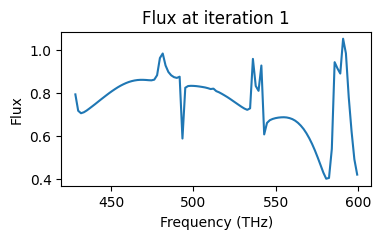

Iteration 2


18:04:48 BST Created task 'task_week05_design_jax_objective_fn_13_fwd' with     
             task_id 'fdve-0fdee930-b656-498c-9f8e-c8808813bb5b' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=112038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=224294;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\taskId]8;;\]8;id=112038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\=]8;;\]8;id=45219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\fdve]8;;\]8;id=112038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\-0fdee930-b65]8;;\
             ]8;id=112038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\6-498c-9f8e-c8808813bb5b']8;;\.

Output()

18:04:51 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:04:57 BST status = preprocess

18:04:59 BST Maximum FlexCredit cost: 0.208. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:07:15 BST status = postprocess

Output()

18:07:35 BST status = success

18:07:36 BST View simulation result at                                          
             ]8;id=825283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=388321;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\taskId]8;;\]8;id=825283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\=]8;;\]8;id=127849;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\fdve]8;;\]8;id=825283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\-0fdee930-b65]8;;\
             ]8;id=825283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0fdee930-b656-498c-9f8e-c8808813bb5b\6-498c-9f8e-c8808813bb5b']8;;\.

Output()

18:07:47 BST loading simulation from data/week05_design_jax_objective_fn_13.hdf5

18:07:48 BST WARNING: Simulation final field decay value of 0.00014 is greater  
             than the simulation shutoff threshold of 1e-06. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

18:07:49 BST WARNING: 101 unique frequencies detected in the output monitors    
             with a minimum spacing of 1.713e+12 (Hz). Setting the 'fwidth' of  
             the adjoint sources to 0.1 times this value = 1.713e+11 (Hz) to    
             avoid spectral overlap. To account for this, the corresponding     
             'run_time' in the adjoint simulation is will be set to 7.458864e-11
             compared to 1.621492e-11 in the forward simulation. If the adjoint 
             'run_time' is large due to small frequency spacing, it could be    
             better to instead run one simulation per frequency, which can be   
             done in parallel using 'tidy3d.plugins.adjoint.web.run_async'.     

18:07:53 BST WARNING: Simulation has 3.19e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'task_week05_design_jax_objective_fn_13_adj' with     
             task_id 'fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=780123;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=257524;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\taskId]8;;\]8;id=780123;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\=]8;;\]8;id=192759;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\fdve]8;;\]8;id=780123;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\-0231786b-65e]8;;\
             ]8;id=780123;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\c-4ad8-8647-6fb9c1f94dcf']8;;\.

Output()

18:08:05 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:08:13 BST status = preprocess

18:09:03 BST Maximum FlexCredit cost: 0.651. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:15:35 BST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

18:15:50 BST status = success

             View simulation result at                                          
             ]8;id=579395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=678702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\taskId]8;;\]8;id=579395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\=]8;;\]8;id=455301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\fdve]8;;\]8;id=579395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\-0231786b-65e]8;;\
             ]8;id=579395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0231786b-65ec-4ad8-8647-6fb9c1f94dcf\c-4ad8-8647-6fb9c1f94dcf']8;;\.

Output()

18:16:07 BST loading simulation from data/week05_design_jax_objective_fn_13.hdf5

	error value: 57.815789501735225
	gradient norm: 0.08306381315139784


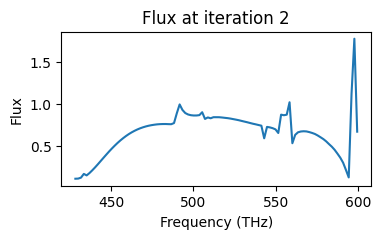

Iteration 3


18:20:18 BST Created task 'task_week05_design_jax_objective_fn_14_fwd' with     
             task_id 'fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=122946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=57503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\taskId]8;;\]8;id=122946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\=]8;;\]8;id=394164;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\fdve]8;;\]8;id=122946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\-734db721-ebf]8;;\
             ]8;id=122946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\d-4a36-9b3e-e4aba399e7fa']8;;\.

Output()

18:20:21 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:20:35 BST status = preprocess

18:20:36 BST You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

18:20:37 BST running solver

Output()

18:22:50 BST status = postprocess

Output()

18:23:04 BST status = success

             View simulation result at                                          
             ]8;id=112770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=470070;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\taskId]8;;\]8;id=112770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\=]8;;\]8;id=767673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\fdve]8;;\]8;id=112770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\-734db721-ebf]8;;\
             ]8;id=112770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734db721-ebfd-4a36-9b3e-e4aba399e7fa\d-4a36-9b3e-e4aba399e7fa']8;;\.

Output()

18:23:16 BST loading simulation from data/week05_design_jax_objective_fn_14.hdf5

             WARNING: Simulation final field decay value of 9.02e-05 is greater 
             than the simulation shutoff threshold of 1e-06. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

18:23:17 BST WARNING: 101 unique frequencies detected in the output monitors    
             with a minimum spacing of 1.713e+12 (Hz). Setting the 'fwidth' of  
             the adjoint sources to 0.1 times this value = 1.713e+11 (Hz) to    
             avoid spectral overlap. To account for this, the corresponding     
             'run_time' in the adjoint simulation is will be set to 7.458864e-11
             compared to 1.621492e-11 in the forward simulation. If the adjoint 
             'run_time' is large due to small frequency spacing, it could be    
             better to instead run one simulation per frequency, which can be   
             done in parallel using 'tidy3d.plugins.adjoint.web.run_async'.     

18:23:21 BST WARNING: Simulation has 3.10e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'task_week05_design_jax_objective_fn_14_adj' with     
             task_id 'fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=950364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=414858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\taskId]8;;\]8;id=950364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\=]8;;\]8;id=11642;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\fdve]8;;\]8;id=950364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\-fc4e4d62-dba]8;;\
             ]8;id=950364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\7-4481-82b0-7afe270d8048']8;;\.

Output()

18:23:33 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:23:41 BST status = preprocess

18:24:33 BST Maximum FlexCredit cost: 0.608. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:30:53 BST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

18:31:11 BST status = success

             View simulation result at                                          
             ]8;id=149322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=789001;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\taskId]8;;\]8;id=149322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\=]8;;\]8;id=449372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\fdve]8;;\]8;id=149322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\-fc4e4d62-dba]8;;\
             ]8;id=149322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc4e4d62-dba7-4481-82b0-7afe270d8048\7-4481-82b0-7afe270d8048']8;;\.

Output()

18:31:26 BST loading simulation from data/week05_design_jax_objective_fn_14.hdf5

	error value: 57.68787400400154
	gradient norm: 0.033311915946613486


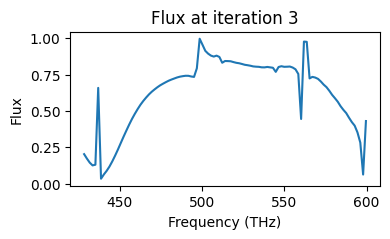

Iteration 4


18:35:30 BST Created task 'task_week05_design_jax_objective_fn_15_fwd' with     
             task_id 'fdve-96f7b963-6461-4ed2-ab1c-85046bd23514' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=175560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=371635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\taskId]8;;\]8;id=175560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\=]8;;\]8;id=312669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\fdve]8;;\]8;id=175560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\-96f7b963-646]8;;\
             ]8;id=175560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\1-4ed2-ab1c-85046bd23514']8;;\.

Output()

18:35:33 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:35:39 BST status = preprocess

18:35:40 BST Maximum FlexCredit cost: 0.183. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:37:51 BST status = postprocess

Output()

18:38:09 BST status = success

18:38:10 BST View simulation result at                                          
             ]8;id=51736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=987138;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\taskId]8;;\]8;id=51736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\=]8;;\]8;id=841279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\fdve]8;;\]8;id=51736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\-96f7b963-646]8;;\
             ]8;id=51736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f7b963-6461-4ed2-ab1c-85046bd23514\1-4ed2-ab1c-85046bd23514']8;;\.

Output()

18:38:22 BST loading simulation from data/week05_design_jax_objective_fn_15.hdf5

             WARNING: Simulation final field decay value of 0.000285 is greater 
             than the simulation shutoff threshold of 1e-06. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

18:38:24 BST WARNING: 101 unique frequencies detected in the output monitors    
             with a minimum spacing of 1.713e+12 (Hz). Setting the 'fwidth' of  
             the adjoint sources to 0.1 times this value = 1.713e+11 (Hz) to    
             avoid spectral overlap. To account for this, the corresponding     
             'run_time' in the adjoint simulation is will be set to 7.458864e-11
             compared to 1.621492e-11 in the forward simulation. If the adjoint 
             'run_time' is large due to small frequency spacing, it could be    
             better to instead run one simulation per frequency, which can be   
             done in parallel using 'tidy3d.plugins.adjoint.web.run_async'.     

18:38:27 BST WARNING: Simulation has 3.04e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'task_week05_design_jax_objective_fn_15_adj' with     
             task_id 'fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=547634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=403596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\taskId]8;;\]8;id=547634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\=]8;;\]8;id=571280;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\fdve]8;;\]8;id=547634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\-000ec12d-be8]8;;\
             ]8;id=547634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\c-4a6a-a613-d3cf37da8aad']8;;\.

Output()

18:38:39 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:38:48 BST status = preprocess

18:39:39 BST Maximum FlexCredit cost: 0.569. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:45:46 BST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

18:45:57 BST status = success

18:45:58 BST View simulation result at                                          
             ]8;id=131996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=888746;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\taskId]8;;\]8;id=131996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\=]8;;\]8;id=796410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\fdve]8;;\]8;id=131996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\-000ec12d-be8]8;;\
             ]8;id=131996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-000ec12d-be8c-4a6a-a613-d3cf37da8aad\c-4a6a-a613-d3cf37da8aad']8;;\.

Output()

18:46:14 BST loading simulation from data/week05_design_jax_objective_fn_15.hdf5

	error value: 51.73092738262507
	gradient norm: 0.1387930331155514


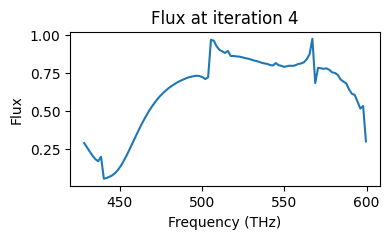

Iteration 5


18:50:21 BST Created task 'task_week05_design_jax_objective_fn_16_fwd' with     
             task_id 'fdve-a5b97e05-71fc-4710-83fa-552621b27bd6' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=571035;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=767886;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\taskId]8;;\]8;id=571035;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\=]8;;\]8;id=387321;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\fdve]8;;\]8;id=571035;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\-a5b97e05-71f]8;;\
             ]8;id=571035;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\c-4710-83fa-552621b27bd6']8;;\.

Output()

18:50:24 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:50:31 BST status = preprocess

             Maximum FlexCredit cost: 0.193. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

18:50:32 BST running solver

Output()

18:52:45 BST status = postprocess

Output()

18:53:01 BST status = success

             View simulation result at                                          
             ]8;id=612170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=252620;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\taskId]8;;\]8;id=612170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\=]8;;\]8;id=271868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\fdve]8;;\]8;id=612170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\-a5b97e05-71f]8;;\
             ]8;id=612170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5b97e05-71fc-4710-83fa-552621b27bd6\c-4710-83fa-552621b27bd6']8;;\.

Output()

18:53:16 BST loading simulation from data/week05_design_jax_objective_fn_16.hdf5

             WARNING: Simulation final field decay value of 5.71e-05 is greater 
             than the simulation shutoff threshold of 1e-06. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

18:53:17 BST WARNING: 101 unique frequencies detected in the output monitors    
             with a minimum spacing of 1.713e+12 (Hz). Setting the 'fwidth' of  
             the adjoint sources to 0.1 times this value = 1.713e+11 (Hz) to    
             avoid spectral overlap. To account for this, the corresponding     
             'run_time' in the adjoint simulation is will be set to 7.458864e-11
             compared to 1.621492e-11 in the forward simulation. If the adjoint 
             'run_time' is large due to small frequency spacing, it could be    
             better to instead run one simulation per frequency, which can be   
             done in parallel using 'tidy3d.plugins.adjoint.web.run_async'.     

18:53:20 BST WARNING: Simulation has 3.13e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'task_week05_design_jax_objective_fn_16_adj' with     
             task_id 'fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=29453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=55528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\taskId]8;;\]8;id=29453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\=]8;;\]8;id=825731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\fdve]8;;\]8;id=29453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\-3aea0600-5c5]8;;\
             ]8;id=29453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\d-45d2-a170-79e7821f3f9b']8;;\.

Output()

18:53:33 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:53:40 BST status = preprocess

18:54:27 BST Maximum FlexCredit cost: 0.605. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

19:00:48 BST early shutoff detected at 12%, exiting.

19:00:49 BST status = postprocess

Output()

19:01:16 BST status = success

             View simulation result at                                          
             ]8;id=908560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=902396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\taskId]8;;\]8;id=908560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\=]8;;\]8;id=341143;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\fdve]8;;\]8;id=908560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\-3aea0600-5c5]8;;\
             ]8;id=908560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3aea0600-5c5d-45d2-a170-79e7821f3f9b\d-45d2-a170-79e7821f3f9b']8;;\.

Output()

19:01:33 BST loading simulation from data/week05_design_jax_objective_fn_16.hdf5

	error value: 47.54318110525417
	gradient norm: 0.006288841537884296


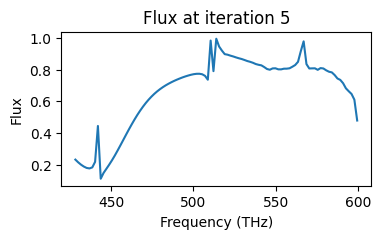

Iteration 6


19:05:30 BST Created task 'task_week05_design_jax_objective_fn_17_fwd' with     
             task_id 'fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=937425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=789826;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\taskId]8;;\]8;id=937425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\=]8;;\]8;id=109095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\fdve]8;;\]8;id=937425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\-69c73aec-a76]8;;\
             ]8;id=937425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\1-4886-ac27-6a5b8a4d5ecb']8;;\.

Output()

19:05:39 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

19:05:46 BST status = preprocess

19:05:47 BST Maximum FlexCredit cost: 0.189. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

19:08:00 BST status = postprocess

Output()

19:08:31 BST status = success

             View simulation result at                                          
             ]8;id=794305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=344620;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\taskId]8;;\]8;id=794305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\=]8;;\]8;id=678074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\fdve]8;;\]8;id=794305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\-69c73aec-a76]8;;\
             ]8;id=794305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69c73aec-a761-4886-ac27-6a5b8a4d5ecb\1-4886-ac27-6a5b8a4d5ecb']8;;\.

Output()

19:08:40 BST loading simulation from data/week05_design_jax_objective_fn_17.hdf5

             WARNING: Simulation final field decay value of 3.58e-05 is greater 
             than the simulation shutoff threshold of 1e-06. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

19:08:41 BST WARNING: 101 unique frequencies detected in the output monitors    
             with a minimum spacing of 1.713e+12 (Hz). Setting the 'fwidth' of  
             the adjoint sources to 0.1 times this value = 1.713e+11 (Hz) to    
             avoid spectral overlap. To account for this, the corresponding     
             'run_time' in the adjoint simulation is will be set to 7.458864e-11
             compared to 1.621492e-11 in the forward simulation. If the adjoint 
             'run_time' is large due to small frequency spacing, it could be    
             better to instead run one simulation per frequency, which can be   
             done in parallel using 'tidy3d.plugins.adjoint.web.run_async'.     

19:08:44 BST WARNING: Simulation has 3.09e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

19:08:45 BST Created task 'task_week05_design_jax_objective_fn_17_adj' with     
             task_id 'fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=476351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=129979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe\taskId]8;;\]8;id=476351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe\=]8;;\]8;id=746531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe\fdve]8;;\]8;id=476351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe\-6be43f5c-92a]8;;\
             ]8;id=476351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6be43f5c-92a3-4389-b665-6ea27e7ca7fe\3-4389-b665-6ea27e7ca7fe']8;;\.

Output()

19:08:57 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

19:09:05 BST status = preprocess

19:09:53 BST Maximum FlexCredit cost: 0.594. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

In [14]:
number_of_iterations = 6
step_size = 0.1
optimizer = optax.adam(learning_rate = step_size)
params_i = PARAMS0.copy()
slab_info_i = params_to_slab_info(params_i)
jsim_i = make_jsim(slab_info_i)

optimizer_state = optimizer.init(params_i)

params_history = [params_i]
error_history = []
grad_norm_history = []
jsim_history = []
jsim_data_history = []
# Flux history is already stored in the flux_history list, in objective_fn function

for i in range(number_of_iterations):
    print(f"Iteration {i + 1}")

    # Compute the value (error) and gradient of the objective function
    (val_i, jsim_data_i), grad_i = val_and_grad_fn(params_i)

    print(f"\terror value: {val_i}")

    # Update the parameters: error (loss) as small as possible
    updates, optimizer_state = optimizer.update(-grad_i, optimizer_state, params_i)
    params_i = optax.apply_updates(params_i, updates)
    grad_norm_i = jnp.linalg.norm(grad_i)

    print(f"\tgradient norm: {grad_norm_i}")

    # Save the optimization history
    params_history.append(params_i.copy())
    error_history.append(val_i)
    grad_norm_history.append(grad_norm_i)
    jsim_data_history.append(jsim_data_i)

    # Visualize the iteration results
    plot_flux(i + 1)

    # Update the structure and simulation
    slab_info_i = params_to_slab_info(params_i)
    jsim_i = make_jsim(slab_info_i)
    jsim_history.append(jsim_i)


### Visualize the iterations

#### Flux history

In [ ]:
# Flux history

fig, axes = plt.subplots(2, 3, figsize = (9, 6))
axes = axes.flatten()
for i, flux in enumerate(flux_history):
    ax = axes[i]
    ax.plot(monitor_freqs / 1e12, flux)
    ax.set_title(f'Flux at iteration {i+1}')
    ax.set_xlabel('Frequency (THz)')
    ax.set_ylabel('Flux')
# fig.delaxes(axes[-1]) # Delete the last subplot if number_of_iterations == 5
plt.tight_layout()
plt.savefig("flux_history.png")
plt.show()

#### Residue history

In [ ]:
# Residue history

fig, axes = plt.subplots(2, 3, figsize = (9, 6))
axes = axes.flatten()
for i, flux in enumerate(flux_history):
    ax = axes[i]
    residue_error = flux - gaussian_y
    ax.plot(monitor_freqs / 1e12, residue_error)
    ax.set_title(f"Iteration {i+1}")
    ax.set_xlabel("Frequency (THz)")
    ax.set_ylabel("Residue error")
# fig.delaxes(axes[-1]) # Delete the last subplot if number_of_iterations == 5
plt.tight_layout()
plt.savefig("residue_history.png")
plt.show()

#### Design parameters history

In [ ]:
# Design parameters history

param_name = ["sub thickness 1", "sub thickness 2", "cuboid L", "cuboid W", "cuboid H"]
slab_info_history = []

for i, params in enumerate(params_history[1:]):
    slab_info_history.append(params_to_slab_info(params))

slab_info_history_transposed = np.array(slab_info_history).T
x = np.arange(number_of_iterations) + 1

fig, axes = plt.subplots(2, 3, figsize = (9, 6))
axes = axes.flatten()

for i, slab_info in enumerate(slab_info_history_transposed):
    ax = axes[i]
    ax.plot(x, slab_info)
    ax.set_title(f"{param_name[i]}")
    ax.set_xlabel("Iteration number")
    ax.set_ylabel(f"Size (microns)")

plt.tight_layout()
plt.delaxes(axes[-1]) 
plt.savefig("design_history.png")
plt.show()

#### Error history and gradient norm history

In [ ]:
# Error history and gradient norm history
fig, axes = plt.subplots(2, 1, figsize = (3, 7))
axes = axes.flatten()

axes[0].plot(x, error_history)
axes[0].set_ylabel("Error")
axes[0].set_title("Error history")

axes[1].plot(x, grad_norm_history)
axes[1].set_xlabel("Iteration number")
axes[1].set_ylabel("Gradient norm")
axes[1].set_title("Gradient norm history")

# Set the x-axis to show only integers
# plt.xticks(x)

plt.savefig("error_and_gradnorm_history.png")
plt.show()

#### 3D plot

In [ ]:
sim6, _ = jsim_history[5].to_simulation()
sim6.plot_3d()